# DOE 本番解析用 (doe-6)

### ライブラリの一括インポート

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

from funcs.tse import get_ticker_name_list

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

## CSV ファイル一覧の取得

In [4]:
name_doe = "doe-6"  # 実験計画名（フォルダ名）
name_code = "7011"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{8})\..+")
if m := pattern_date.match(file_last):
    date_str = m.group(1)  # 保存ファイル目に付与する日付
else:
    date_str = "00000000"
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['ticks_20250819.csv', 'ticks_20250820.csv', 'ticks_20250821.csv', 'ticks_20250822.csv', 'ticks_20250825.csv', 'ticks_20250826.csv', 'ticks_20250827.csv', 'ticks_20250828.csv', 'ticks_20250829.csv', 'ticks_20250901.csv', 'ticks_20250902.csv', 'ticks_20250903.csv', 'ticks_20250904.csv', 'ticks_20250905.csv', 'ticks_20250908.csv', 'ticks_20250909.csv', 'ticks_20250910.csv', 'ticks_20250911.csv', 'ticks_20250912.csv', 'ticks_20250916.csv', 'ticks_20250917.csv', 'ticks_20250918.csv', 'ticks_20250919.csv', 'ticks_20250922.csv', 'ticks_20250924.csv', 'ticks_20250925.csv', 'ticks_20250926.csv', 'ticks_20250929.csv', 'ticks_20250930.csv', 'ticks_20251001.csv', 'ticks_20251002.csv', 'ticks_20251003.csv', 'ticks_20251006.csv', 'ticks_20251007.csv', 'ticks_20251008.csv', 'ticks_20251009.csv', 'ticks_20251010.csv', 'ticks_20251014.csv', 'ticks_20251015.csv', 'ticks_20251016.csv', 'ticks_20251017.csv', 'ticks_20251020.csv', 'ticks_20251021.csv', 'ticks_20251022.csv', 'ticks_2025

## CSV ファイルの読み込み、連結

In [5]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    if i == 0:
        print("\n日毎のシミュレーション結果例（連結前）")
        print(df_tick)
    list_df.append(df_tick)

df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)


日毎のシミュレーション結果例（連結前）
                    file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
0    ticks_20250819.xlsx  8306      6           30          300   31.0
1    ticks_20250819.xlsx  8306      4           45          300   35.0
2    ticks_20250819.xlsx  8306     10           60          300   27.0
3    ticks_20250819.xlsx  8306      8           75          300   30.0
4    ticks_20250819.xlsx  8306      4           90          300   31.0
..                   ...   ...    ...          ...          ...    ...
116  ticks_20250819.xlsx  8306      4          120          900   12.5
117  ticks_20250819.xlsx  8306      4          135          900   12.0
118  ticks_20250819.xlsx  8306      2          150          900   -5.0
119  ticks_20250819.xlsx  8306      2          165          900   18.5
120  ticks_20250819.xlsx  8306      4          180          900   18.5

[121 rows x 6 columns]

日毎のシミュレーション結果を連結したデータフレーム
                      file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
0  

## サマリ統計の算出

In [6]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["total"]

# 因子ごとに応答の平均を集計（サマリデータ）
df_summary = df.groupby(factor_cols)[response_cols].mean().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary = df_summary.sort_values(["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True)
print("サマリ統計")
print(df_summary)

# HTML 形式で出力
styled = df_summary.style.format(
    {"trade": "{:.1f}", "total": "{:.2f}"}
).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)
html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_summary.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

サマリ統計
     PERIOD_MA_1  PERIOD_MA_2     total
0             30          300 -0.560241
1             45          300  0.469880
2             60          300 -0.825301
3             75          300 -0.981928
4             90          300 -0.933735
..           ...          ...       ...
116          120          900 -0.716867
117          135          900 -0.602410
118          150          900  0.006024
119          165          900 -1.066265
120          180          900 -0.807229

[121 rows x 3 columns]


## 平均収益の集計

In [7]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

## 平均収益の算出

In [8]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    if i == 0:
        print("日毎のシミュレーション結果 (total のみ）例（連結前の Series）")
        print(ser)
    list_ser.append(ser)
# pd.Series を結合して転置
df_mean = pd.concat(list_ser, axis=1).T
print("\ndf_mean: まだ平均値ではなく、その日の収益（Series を連結）")
print(df_mean)

# データスコープを示す文字列
dt_start = df_mean.index[0]
dt_end = df_mean.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

# 平均収益の算出
n = len(df_mean.index)
while n > 0:
    # 最下行から順に平均値を算出して、行の内容を置換。
    df_mean.iloc[n - 1] = df_mean[:n].mean()
    n -= 1
print("\ndf_mean: 新しい日付から古い日付と逆順に平均収益を算出")
print(df_mean)

# 最終日の平均収益のランキング
ser_ranking = df_mean.iloc[len(df_mean) - 1].sort_values(ascending=False)
print("最新の平均収益（逆ソート後）")
print(ser_ranking)

日毎のシミュレーション結果 (total のみ）例（連結前の Series）
0      31.0
1      35.0
2      27.0
3      30.0
4      31.0
       ... 
116    12.5
117    12.0
118    -5.0
119    18.5
120    18.5
Name: 2025-08-19 00:00:00, Length: 121, dtype: float64

df_mean: まだ平均値ではなく、その日の収益（Series を連結）
             0     1     2     3     4     5     6     7    8     9    ...  \
2025-08-19  31.0  35.0  27.0  30.0  31.0  22.0  22.5  15.5 -4.5  18.0  ...   
2025-08-20  -1.5  10.0  20.0  24.5  10.5   5.5  16.0  14.0  3.0   9.5  ...   
2025-08-21  23.5  25.5   9.5  10.0   5.5   7.0  18.5  17.5  6.5   0.0  ...   
2025-08-22   1.0   0.0   1.0  -2.5   3.0  -0.5 -11.5 -10.5 -4.0  -9.5  ...   
2025-08-25  26.5  28.0   4.0   1.5  31.5  28.0   2.0   3.0  3.0  24.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...  ...   ...  ...   
2025-12-12   2.5   2.5   0.0   4.0  12.0  12.0  13.0  -6.0 -2.0  -2.0  ...   
2025-12-15  -5.5 -10.5  -6.0  -5.5 -11.5 -15.5  -9.5  -7.0 -3.0  -1.5  ...   
2025-12-16  -1.5   8.5  19.0   1.

### 検算

In [9]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均収益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary["total"] - df_mean.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング

In [10]:
# トップランキング
n_top = 5
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary.iloc[best_conditions]
print("---\n[Best Conditions]")
print(df_best)

# HTML 形式で出力
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_best.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新の平均収益が負になっている実験条件
negative_condition = ser_ranking[ser_ranking < 0].index
df_negative = df_summary.iloc[negative_condition]
print("---\n[Bad Conditions]")
print(df_negative)

# HTML 形式で出力
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_negative.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

---
[Best Conditions]
    PERIOD_MA_1  PERIOD_MA_2     total
16          105          360  2.475904
60          105          600  2.301205
27          105          420  2.072289
71          105          660  1.927711
93          105          780  1.849398
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2     total
8            150          300 -0.096386
98           180          780 -0.114458
14            75          360 -0.114458
57            60          600 -0.150602
24            60          420 -0.174699
72           120          660 -0.210843
20           165          360 -0.210843
59            90          600 -0.210843
87           180          720 -0.289157
81            90          720 -0.301205
109          180          840 -0.307229
42           165          480 -0.319277
86           165          720 -0.319277
9            165          300 -0.373494
21           180          360 -0.427711
114           90          900 -0.512048
107          150          840 -0.548193
0  

## 実験条件毎の収益トレンド

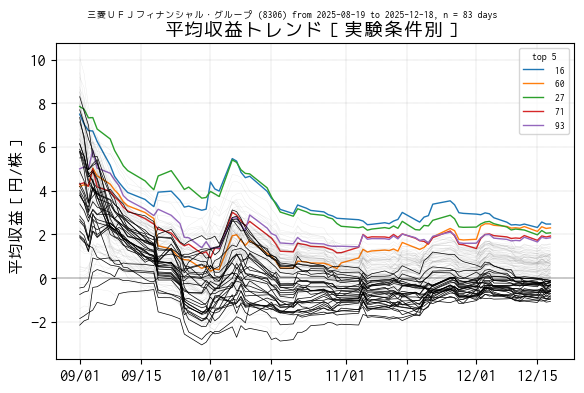

In [11]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_mean[dt_from <= df_mean.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップ 5 だけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_condition:  # 最新の平均収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("平均収益［円/株］")
ax.set_title("平均収益トレンド［実験条件別］")
# 凡例
lg = ax.legend(fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_mean_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

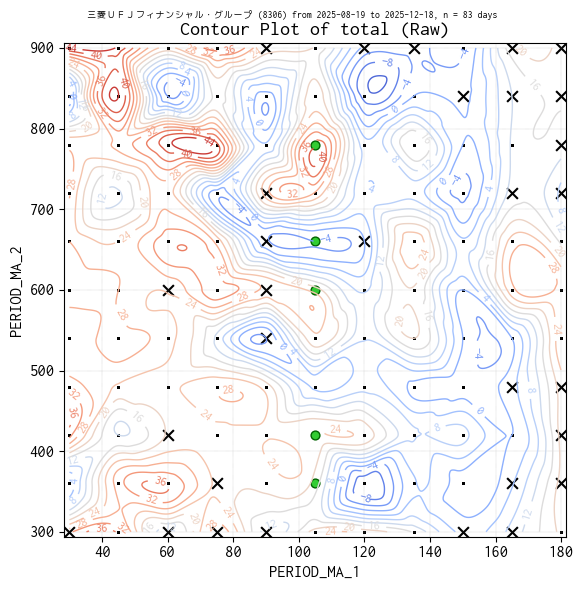

In [12]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# Contour Map
cont = ax.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm", linewidths=1)
ax.clabel(cont, inline=True, fontsize=9)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title("Contour Plot of total (Raw)")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_best[col_x],
    df_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
ax.scatter(
    df_negative[col_x],
    df_negative[col_y],
    marker="x",
    color="black",
    s=60,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_raw_contour_{target}.png"
)

plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

最高収益
                     file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
3938  ticks_20251006.xlsx  8306     22           30          660   85.0
3949  ticks_20251006.xlsx  8306     18           30          720   85.0

最低収益
                     file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
1762  ticks_20250908.xlsx  8306     20           60          660  -45.0



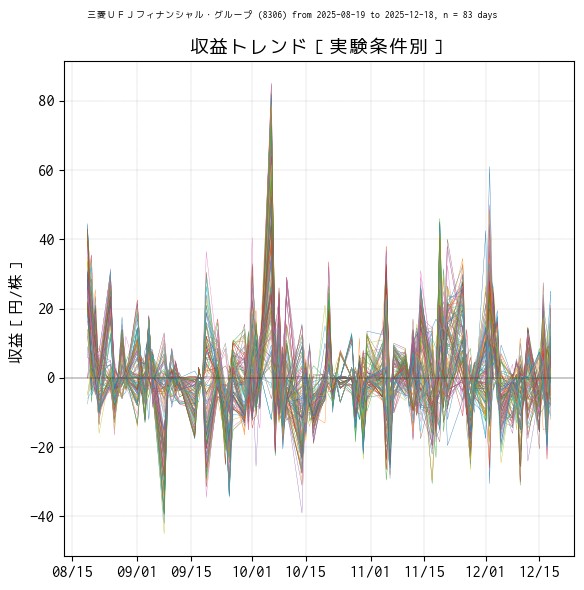

In [13]:
# 実験水準
list_factor_1 = sorted(list(set(df[factor_cols[0]])))
list_factor_2 = sorted(list(set(df[factor_cols[1]])))
profit_max = -np.inf
profit_min = +np.inf
# ---------------------------------------------------------
# 実験条件毎の収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

for factor_1 in list_factor_1:
    for factor_2 in list_factor_2:
        df_profit = df[
            (df[factor_cols[0]] == factor_1) & (df[factor_cols[1]] == factor_2)
        ]
        df_profit.index = [get_date_from_file(file) for file in df_profit["file"]]

        profit_max_local = df_profit["total"].max()
        if profit_max < profit_max_local:
            profit_max = profit_max_local

        profit_min_local = df_profit["total"].min()
        if profit_min_local < profit_min:
            profit_min = profit_min_local
        n_cond = int(
            df_summary[
                (df_summary[factor_cols[0]] == factor_1)
                & (df_summary[factor_cols[1]] == factor_2)
            ].index[0]
        )
        ax.plot(df_profit["total"], linewidth=0.25, label=f"{n_cond}")

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("収益［円/株］")
ax.set_title("収益トレンド［実験条件別］")
# 凡例
# lg = ax.legend(fontsize=7)
# lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

print("最高収益")
print(df[df["total"] == profit_max])
print("\n最低収益")
print(df[df["total"] == profit_min])
print()

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
# plt.savefig(output)
plt.show()

## メディアン収益の算出

In [14]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    if i == 0:
        print("日毎のシミュレーション結果 (total のみ）例（連結前の Series）")
        print(ser)
    list_ser.append(ser)
# pd.Series を結合して転置
df_median = pd.concat(list_ser, axis=1).T
print("\ndf_median: まだメディアンではなく、その日の収益（Series を連結）")
print(df_median)

# データスコープを示す文字列
dt_start = df_median.index[0]
dt_end = df_median.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

日毎のシミュレーション結果 (total のみ）例（連結前の Series）
0      31.0
1      35.0
2      27.0
3      30.0
4      31.0
       ... 
116    12.5
117    12.0
118    -5.0
119    18.5
120    18.5
Name: 2025-08-19 00:00:00, Length: 121, dtype: float64

df_median: まだメディアンではなく、その日の収益（Series を連結）
             0     1     2     3     4     5     6     7    8     9    ...  \
2025-08-19  31.0  35.0  27.0  30.0  31.0  22.0  22.5  15.5 -4.5  18.0  ...   
2025-08-20  -1.5  10.0  20.0  24.5  10.5   5.5  16.0  14.0  3.0   9.5  ...   
2025-08-21  23.5  25.5   9.5  10.0   5.5   7.0  18.5  17.5  6.5   0.0  ...   
2025-08-22   1.0   0.0   1.0  -2.5   3.0  -0.5 -11.5 -10.5 -4.0  -9.5  ...   
2025-08-25  26.5  28.0   4.0   1.5  31.5  28.0   2.0   3.0  3.0  24.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...  ...   ...  ...   
2025-12-12   2.5   2.5   0.0   4.0  12.0  12.0  13.0  -6.0 -2.0  -2.0  ...   
2025-12-15  -5.5 -10.5  -6.0  -5.5 -11.5 -15.5  -9.5  -7.0 -3.0  -1.5  ...   
2025-12-16  -1.5   8.5  19.0 

In [15]:
n = len(df_median.index)

In [16]:
df_median[:n].median()

0     -1.5
1     -0.5
2     -1.5
3     -1.0
4     -1.5
      ... 
116   -1.0
117   -1.0
118    0.0
119    0.0
120    0.0
Length: 121, dtype: float64

In [17]:
# メディアン収益の算出
n = len(df_median.index)
while n > 0:
    # 最下行から順にメディアンを算出して、行の内容を置換。
    df_median.iloc[n - 1] = df_median[:n].median()
    n -= 1
print("\ndf_median: 新しい日付から古い日付と逆順にメディアン収益を算出")
print(df_median)

# 最終日の平均収益のランキング
ser_ranking = df_median.iloc[len(df_median) - 1].sort_values(ascending=False)
print("最新のメディアン収益（逆ソート後）")
print(ser_ranking)


df_median: 新しい日付から古い日付と逆順にメディアン収益を算出
              0      1      2      3      4      5      6      7     8    \
2025-08-19  31.00  35.00  27.00  30.00  31.00  22.00  22.50  15.50 -4.50   
2025-08-20  14.75  22.50  23.50  27.25  20.75  13.75  19.25  14.75 -0.75   
2025-08-21  23.50  25.50  20.00  24.50  10.50   7.00  18.50  15.50  3.00   
2025-08-22  12.25  17.75  14.75  17.25   8.00   6.25  17.25  14.75 -0.50   
2025-08-25  23.50  25.50   9.50  10.00  10.50   7.00  16.00  14.00  3.00   
...           ...    ...    ...    ...    ...    ...    ...    ...   ...   
2025-12-12  -1.50  -1.00  -1.50  -1.00  -1.50   0.00   0.00   0.00 -0.50   
2025-12-15  -1.50  -1.25  -1.75  -1.00  -1.50   0.00   0.00   0.00 -0.50   
2025-12-16  -1.50  -1.00  -1.50  -1.00  -1.50   0.00   0.00   0.00 -0.50   
2025-12-17  -1.50  -0.75  -1.50  -1.00  -1.50   0.00   0.00   0.00 -0.50   
2025-12-18  -1.50  -0.50  -1.50  -1.00  -1.50   0.00   0.00   0.00 -0.50   

              9    ...    111    112    113   114

## サマリ統計（メディアン）

In [18]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["total"]

# 因子ごとに応答のメディアンを集計（サマリデータ）
df_summary_2 = df.groupby(factor_cols)[response_cols].median().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary_2 = df_summary_2.sort_values(
    ["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True
)
print("サマリ統計（メディアン）")
print(df_summary_2)

サマリ統計（メディアン）
     PERIOD_MA_1  PERIOD_MA_2  total
0             30          300   -1.5
1             45          300   -0.5
2             60          300   -1.5
3             75          300   -1.0
4             90          300   -1.5
..           ...          ...    ...
116          120          900   -1.0
117          135          900   -1.0
118          150          900    0.0
119          165          900    0.0
120          180          900    0.0

[121 rows x 3 columns]


### 検算

In [19]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均収益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary_2["total"] - df_median.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング (2)

In [20]:
# トップランキング
n_top = 5
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary_2.iloc[best_conditions]
print("---\n[Best Conditions]")
print(df_best)

# 最新の平均収益が負になっている実験条件
negative_condition = ser_ranking[ser_ranking < 0].index
df_negative = df_summary_2.iloc[negative_condition]
print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
    PERIOD_MA_1  PERIOD_MA_2  total
6           120          300    0.0
5           105          300    0.0
7           135          300    0.0
16          105          360    0.0
21          180          360    0.0
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2  total
58            75          600   -0.5
68            60          660   -0.5
103           90          840   -0.5
112           60          900   -0.5
23            45          420   -0.5
18           135          360   -0.5
17           120          360   -0.5
14            75          360   -0.5
1             45          300   -0.5
37            90          480   -0.5
40           135          480   -0.5
48            90          540   -0.5
30           150          420   -0.5
8            150          300   -0.5
57            60          600   -0.5
101           60          840   -0.5
91            75          780   -0.5
90            60          780   -0.5
80            75          720   -0.5
2

## 実験条件毎の収益トレンド（メディアン）

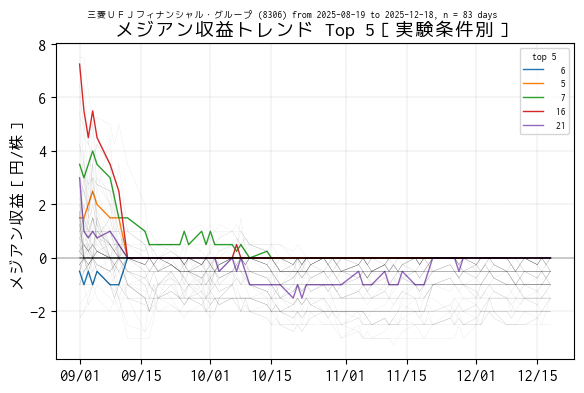

In [21]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_median[dt_from <= df_median.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップ 5 だけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    # elif colname in negative_condition:  # 最新の平均収益が負になっている条件
    #    ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black", alpha=0.1)
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("メジアン収益［円/株］")
ax.set_title("メジアン収益トレンド Top 5［実験条件別］")
# 凡例
lg = ax.legend(fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_median_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
# plt.savefig(output)
plt.show()